In [27]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.base import clone

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")


In [2]:
data_transactions = pd.read_json("../transactions.json", lines=True)
data_merchants = pd.read_csv("../merchants.csv")
data_users = pd.read_csv("../users.csv")

In [3]:
location_df = pd.json_normalize(data_transactions['location'])
location_df.columns = ['latitude', 'longitude']

data_transactions = data_transactions.drop(columns=['location']).join(location_df)

In [4]:
df = data_transactions.merge(data_merchants, on='merchant_id', how='left').merge(data_users, on='user_id', how='left')

In [5]:
df["education"] = df["education"].fillna("No Education")  # nan -> wykształcenie niższe niż średnie
df["education"].value_counts()

education
PhD             103760
Master          100526
Bachelor        100325
High School      98823
No Education     96566
Name: count, dtype: int64

In [6]:
df_cleaned = df.drop(columns = ["transaction_id", "currency"])

In [7]:
# Sort by user_id and timestamp for user-based features
df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"])
df_cleaned = df_cleaned.reset_index(drop=True) # Ensure unique, sequential index

# User fraud history
df_cleaned['temp_cumulative_fraud'] = df_cleaned.groupby('user_id')['is_fraud'].cumsum()
shifted_cumulative_fraud = df_cleaned.groupby('user_id')['temp_cumulative_fraud'].shift(1)
df_cleaned['user_has_fraud_history'] = shifted_cumulative_fraud.fillna(0).gt(0).astype(int)
df_cleaned = df_cleaned.drop(columns=['temp_cumulative_fraud'])

# User transaction count
df_cleaned["dummy"] = np.ones(len(df_cleaned))
df_cleaned["users_transaction_count"] = df_cleaned.groupby("user_id")["dummy"].cumsum().astype(int)
df_cleaned = df_cleaned.drop(columns=["dummy"])

# Time since last transaction for user
df_cleaned['time_since_last_transaction_user'] = df_cleaned.groupby('user_id')['timestamp'].diff().dt.days
df_cleaned['time_since_last_transaction_user'] = df_cleaned['time_since_last_transaction_user'].fillna(0).astype(int)

# Transaction amount statistics for user
user_amount_mean_shifted = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.expanding().mean().shift(1))
user_amount_std_shifted = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.expanding().std().shift(1))
df_cleaned['transaction_amount_std_from_user_mean'] = (df_cleaned['amount'] - user_amount_mean_shifted) / user_amount_std_shifted
df_cleaned['transaction_amount_std_from_user_mean'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned['transaction_amount_std_from_user_mean'].fillna(0, inplace=True)

# Days since signup
df_cleaned['signup_date'] = pd.to_datetime(df_cleaned['signup_date'])
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['timestamp'], unit='ms')
df_cleaned['days_since_signup'] = (df_cleaned['transaction_date'] - df_cleaned['signup_date']).dt.total_seconds() / (24*3600)

# Transaction time features
df_cleaned['transaction_hour'] = df_cleaned['transaction_date'].dt.hour
df_cleaned['is_transaction_night'] = ((df_cleaned['transaction_hour'] >= 0) & (df_cleaned['transaction_hour'] < 6)).astype(int)

# Helper function for rolling count
def rolling_count(series, window):
    # series is a DataFrame with 'transaction_date'
    return series['transaction_date'].apply(
        lambda x: ((series['transaction_date'] >= (x - pd.Timedelta(window))) & (series['transaction_date'] < x)).sum()
    )

# Calculate transactions in the last 1 hour for each user
df_cleaned['transactions_last_1h_user'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '1h'))
    .sort_index()
)

# Calculate transactions in the last 24 hours for each user
df_cleaned['transactions_last_24h_user'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '24h'))
    .sort_index()
)

# Average amount of last 5 transactions for user
df_cleaned['avg_amount_last_5_tx_user'] = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
df_cleaned['avg_amount_last_5_tx_user'].fillna(0, inplace=True)

# Sort by merchant_id and timestamp for merchant-based features
df_cleaned = df_cleaned.sort_values(by=["merchant_id", "timestamp"])
df_cleaned = df_cleaned.reset_index(drop=True) # Reset index again

# Merchant fraud history
df_cleaned['temp_cumulative_fraud'] = df_cleaned.groupby('merchant_id')['is_fraud'].cumsum()
shifted_cumulative_fraud = df_cleaned.groupby('merchant_id')['temp_cumulative_fraud'].shift(1)
df_cleaned['merchant_has_fraud_history'] = shifted_cumulative_fraud.fillna(0).gt(0).astype(int)
df_cleaned = df_cleaned.drop(columns=['temp_cumulative_fraud'])

df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]) # Consistent sorting
df_cleaned = df_cleaned.reset_index(drop=True) # Clean index

def _get_user_device_mode_for_transform(series):
    # Ensure numpy is imported in your notebook, e.g., import numpy as np
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return np.nan

df_cleaned['user_mode_device_temp'] = df_cleaned.groupby('user_id')['device'].transform(_get_user_device_mode_for_transform)
df_cleaned['device_changed'] = 0
has_mode_device = df_cleaned['user_mode_device_temp'].notna()
df_cleaned.loc[has_mode_device, 'device_changed'] = \
    (df_cleaned.loc[has_mode_device, 'device'] != df_cleaned.loc[has_mode_device, 'user_mode_device_temp']).astype(int)

#Change datatypes if necessary
df_cleaned['days_since_signup'] = df_cleaned['days_since_signup'].astype(int)

# Clean up temporary columns
df_features_added = df_cleaned.drop(columns=['transaction_date', 'signup_date'])


In [8]:
# drop the data with time-delta info
df_features_added = df_cleaned.drop(columns=['transaction_date', 'signup_date', 'timestamp'])

In [9]:
enc = OrdinalEncoder()

X = df_features_added.drop(columns=["is_fraud"])
y = df_features_added["is_fraud"]

X = pd.DataFrame(enc.fit_transform(X), columns=X.columns)

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X, y)

Tune the model a little bit before RFE

In [10]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1,
        "eval_metric": "logloss",
        "use_label_encoder": False,
    }
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_res, y_res, cv=cv, scoring="f1").mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best F1:", study.best_value)

[I 2025-05-16 11:31:54,997] A new study created in memory with name: no-name-e81dc092-673f-491c-aa4a-36721bf1233a
[I 2025-05-16 11:31:56,719] Trial 0 finished with value: 0.5255938070740283 and parameters: {'learning_rate': 0.22373541991941245, 'n_estimators': 151, 'max_depth': 10, 'subsample': 0.6939173183623076, 'colsample_bytree': 0.980852115076105, 'gamma': 4.0645605863129415}. Best is trial 0 with value: 0.5255938070740283.
[I 2025-05-16 11:31:58,242] Trial 1 finished with value: 0.5582640670633255 and parameters: {'learning_rate': 0.140181491252103, 'n_estimators': 262, 'max_depth': 7, 'subsample': 0.7875901842275097, 'colsample_bytree': 0.7137295181356279, 'gamma': 4.920482578620879}. Best is trial 1 with value: 0.5582640670633255.
[I 2025-05-16 11:31:59,572] Trial 2 finished with value: 0.5475951698427374 and parameters: {'learning_rate': 0.20660421013735963, 'n_estimators': 138, 'max_depth': 4, 'subsample': 0.6183405093813197, 'colsample_bytree': 0.7263996587909184, 'gamma': 4

KeyboardInterrupt: 

In [ ]:
def rfe_with_cv(
    model_prototype,
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    scoring = make_scorer(f1_score),
    random_state: int = 42):
    
    # Initialization
    features = X.columns.tolist()
    best_score = -np.inf
    best_features = features.copy()
    f1_history = {}

    # CV strategy
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    # Iterative elimination
    while features:
        # Evaluate current feature set via cross-validation
        model = clone(model_prototype)
        scores = cross_val_score(
            model,
            X[features],
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = np.mean(scores)
        f1_history[len(features)] = mean_score

        # Update best if improved (or same score with fewer features)
        if mean_score > best_score or (
            np.isclose(mean_score, best_score) and len(features) < len(best_features)
        ):
            best_score = mean_score
            best_features = features.copy()

        # Stop if only one feature remains
        if len(features) == 1:
            break

        # Fit on the full data to get importances
        model_full = clone(model_prototype)
        model_full.fit(X[features], y)
        importances = pd.Series(
            model_full.feature_importances_,
            index=features
        )
        # Eliminate least important feature
        least_imp = importances.idxmin()
        features.remove(least_imp)

    print(
        f"RFE done: best F1={best_score:.4f} with {len(best_features)} features."
    )
    return best_features, f1_history


best_params = {'learning_rate': 0.06225274336620078, 'n_estimators': 234, 'max_depth': 6, 'subsample': 0.9725262870020678, 'colsample_bytree': 0.729999223316507, 'gamma': 4.67092391014463}

xgb_prototype = XGBClassifier(**best_params)
best_feats, history = rfe_with_cv(xgb_prototype, X_res, y_res)

RFE done: best F1=0.5803 with 3 features.


Now with reduce feature size lets run Optuna with Stratified KFold again to tune the final model

In [18]:
# Use only the RFE-selected features
X_rfe = X_res[best_feats]

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1,
        "eval_metric": "logloss",
        "use_label_encoder": False,
    }
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_rfe, y_res, cv=cv, scoring="f1").mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60, n_jobs=-1)

print("Best params:", study.best_params)
print("Best F1:", study.best_value)

[I 2025-05-16 11:35:09,473] A new study created in memory with name: no-name-eee53ead-7f53-484b-9731-f76b26773595
[I 2025-05-16 11:35:16,990] Trial 3 finished with value: 0.573690725868236 and parameters: {'learning_rate': 0.25289216347572296, 'n_estimators': 78, 'max_depth': 8, 'subsample': 0.6360403694996292, 'colsample_bytree': 0.7631672937968463, 'gamma': 2.8841203235875783}. Best is trial 3 with value: 0.573690725868236.
[I 2025-05-16 11:35:23,759] Trial 6 finished with value: 0.5770290190095675 and parameters: {'learning_rate': 0.22037001077821614, 'n_estimators': 223, 'max_depth': 6, 'subsample': 0.8912294156760953, 'colsample_bytree': 0.8055847246213751, 'gamma': 4.675107875445141}. Best is trial 6 with value: 0.5770290190095675.
[I 2025-05-16 11:35:25,167] Trial 1 finished with value: 0.5758467164108294 and parameters: {'learning_rate': 0.1780878285231242, 'n_estimators': 214, 'max_depth': 9, 'subsample': 0.8229042473403542, 'colsample_bytree': 0.984813298067749, 'gamma': 2.38

Best params: {'learning_rate': 0.02977236334328825, 'n_estimators': 164, 'max_depth': 2, 'subsample': 0.8769005899819794, 'colsample_bytree': 0.7688267618975224, 'gamma': 2.456043935544535}
Best F1: 0.5803059047295184


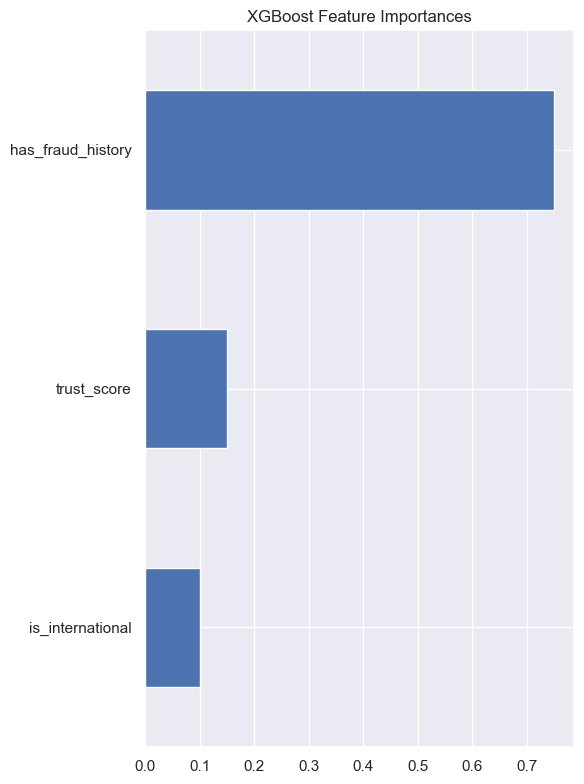

In [19]:
final_model = XGBClassifier(**study.best_params)
final_model.fit(X_res[best_feats], y_res)

importances = pd.Series(final_model.feature_importances_, index=best_feats)
importances.sort_values().plot(kind='barh', figsize=(6,8))
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

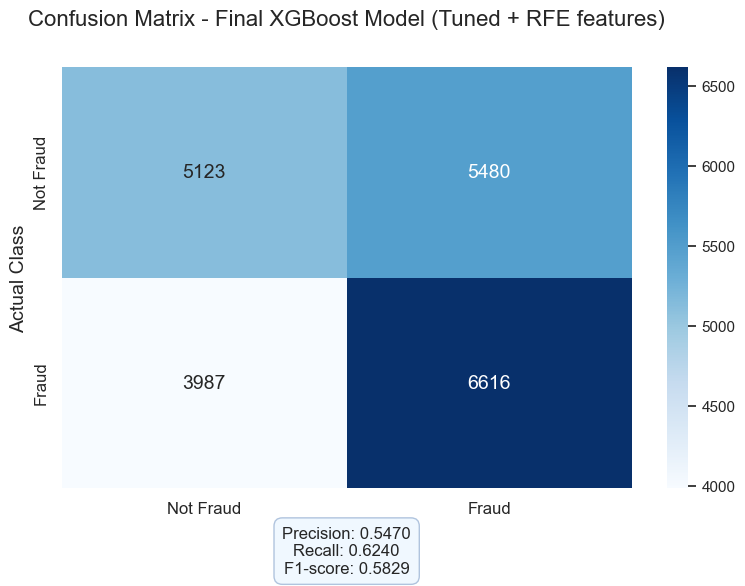

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_res[best_feats], y_res, stratify=y_res, shuffle=True, random_state=42)

final_model = XGBClassifier(**study.best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Define class labels for the plot
class_labels = ['Not Fraud', 'Fraud']

# Plotting the confusion matrix
plt.figure(figsize=(8, 7)) # Increased figure height slightly to accommodate metrics
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 14}) # Makes annotations easier to read

plt.title('Confusion Matrix - Final XGBoost Model (Tuned + RFE features)', fontsize=16, y=1.08) # Adjust title position
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding precision, recall, and F1-score text below the heatmap
metrics_text = f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}"
plt.text(0.5, -0.15, metrics_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='lightsteelblue', lw=1))


plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent labels/text from overlapping, added bottom margin
plt.show()
